# Analyzing Toronto Power Demand Data (2016-2018)



In [27]:
%matplotlib inline

import sys
import statsmodels as ss
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [28]:
# Read the demand data for past 3 years
df =  pd.read_csv("data/power_data.csv", parse_dates=['Date'])
df.head()

,Date,Hour,Ontario Demand,Northwest,Northeast,Ottawa,East,Toronto,Essa,Bruce,Southwest,Niagara,West,Zone Total,Diff
0,2016-01-01,1,13417,479,1318,783,965,4789,867,57,2603,377,1212,13451,33
1,2016-01-01,2,12968,473,1281,715,975,4597,829,59,2491,377,1183,12979,11
2,2016-01-01,3,12395,464,1158,693,945,4441,796,65,2392,365,1135,12454,59
3,2016-01-01,4,12228,447,1170,681,923,4332,776,48,2349,352,1118,12195,-33
4,2016-01-01,5,12116,432,1182,676,926,4272,774,63,2307,349,1108,12089,-28


In [29]:
df1 = df[["Date", "Hour", "Toronto"]]
df1 = df1.loc[df['Date'].dt.year == 2018  ] 
df1 = df1.loc[df['Date'].dt.month == 1]
df1.head()


,Date,Hour,Toronto
17544,2018-01-01,1,5340
17545,2018-01-01,2,5211
17546,2018-01-01,3,5096
17547,2018-01-01,4,4987
17548,2018-01-01,5,4926


In [30]:
df1.describe()


,Hour,Toronto
count,744.000000,744.00000
mean,12.500000,5916.69086
std,6.926843,747.80109
min,1.000000,4191.00000
25%,6.750000,5275.00000
50%,12.500000,6095.00000
75%,18.250000,6559.00000
max,24.000000,7253.00000


In [31]:
ss_decomposition = seasonal_decompose(x=df1["Toronto"], model='multiplicative', freq=6)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

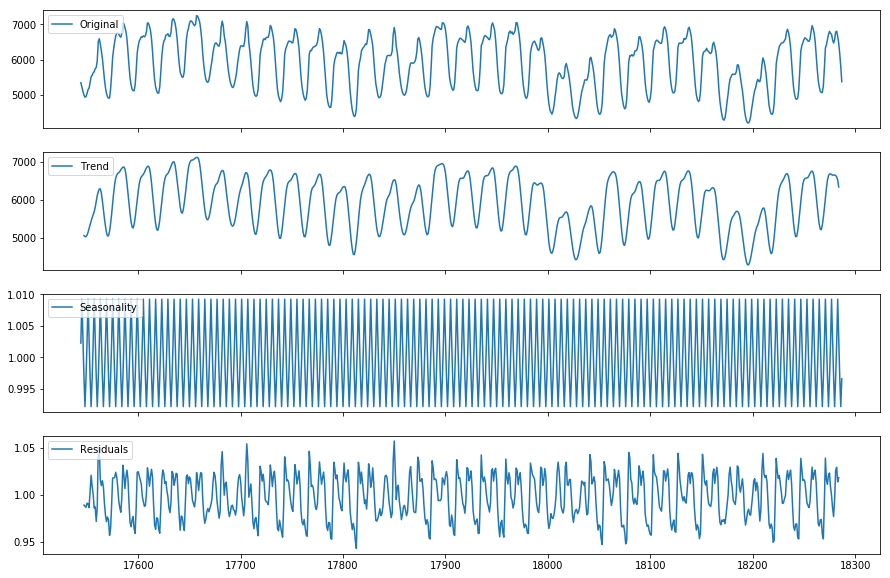

In [32]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(df1["Toronto"], label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');

Text(0.5, 0, 'Hour')

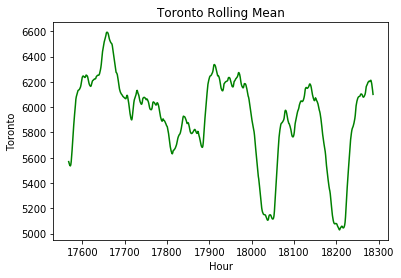

In [33]:
pd.Series.rolling(df1["Toronto"], window=25).mean().plot(style="-g")
plt.title("Toronto Rolling Mean")
plt.ylabel("Toronto")
plt.xlabel("Hour")

Text(0.5, 0, 'Power Demand')

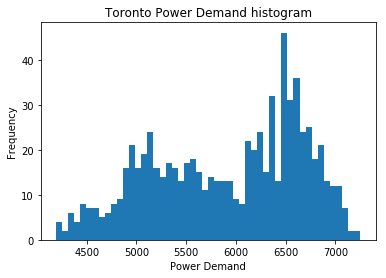

In [34]:
plt.figure()
df1["Toronto"].plot(kind="hist", stacked=True, bins=50)
plt.title("Toronto Power Demand histogram")
plt.xlabel("Power Demand")

In [35]:
def run_sequence_plot(x, y, title, xlabel="time", ylabel="series"):
    plt.plot(x, y, 'k-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3);

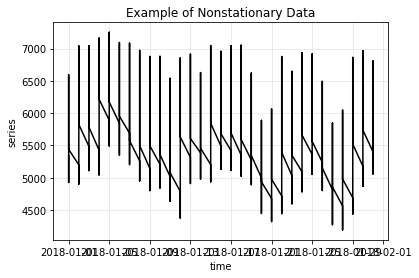

In [36]:
run_sequence_plot(df1["Date"], df1["Toronto"],
                  title="Example of Nonstationary Data")

In [37]:
# split data into 10 chunks
chunks = np.split(df1["Toronto"], indices_or_sections=10)
# compare means and variances
print("{} | {:7} | {}".format("Chunk", "Mean", "Variance"))
print("-" * 26)
for i, chunk in enumerate(chunks, 1):
    print("{:5} | {:.6} | {:.6}".format(i, np.mean(chunk), np.var(chunk)))

ValueError: array split does not result in an equal division

In [ ]:
pd.Series(df1["Toronto"]).hist();

In [38]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df1["Toronto"])

In [39]:
print(adf)

-1.7801271590899554


In [40]:
print(pvalue)

0.390371680826751


In [41]:
print(nobs)

723


In [42]:
print(critical_values)

{'1%': -3.4394269973845657, '5%': -2.8655458544300387, '10%': -2.568903174551249}


In [43]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df1["Toronto"], regression='c')
print("ADF: ", adf)
print("p-value:", pvalue)

ADF:  -1.7801271590899554
p-value: 0.390371680826751


In [44]:
lagged = df1["Toronto"].shift(24).dropna()
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(lagged, regression='c')
print("ADF: ", adf)
print("p-value:", pvalue)

ADF:  -1.7788419744978916
p-value: 0.3910154994274842


In [45]:
# find mean of series
stationary_time_series_avg = np.mean(df1["Toronto"])

# create array composed of mean value and equal to length of time array
sts_avg = np.full(shape=len(df1["Date"]), fill_value=stationary_time_series_avg, dtype='float')

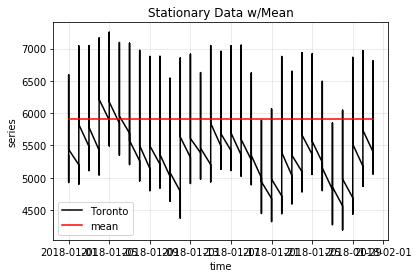

In [46]:
run_sequence_plot(df1["Date"], df1["Toronto"],
                  title="Stationary Data w/Mean")
plt.plot(df1["Date"], sts_avg, 'r', label="mean")
plt.legend();

In [47]:
def mse(observations, estimates):
    '''
    INPUT:
        observations - numpy array of values indicating observed values
        estimates - numpy array of values indicating an estimate of values
    OUTPUT:
        Mean Square Error value
    '''
    # check arg types
    assert type(observations) == type(np.array([])), "'observations' must be a numpy array"
    assert type(estimates) == type(np.array([])), "'estimates' must be a numpy array"
    # check length of arrays equal
    assert len(observations) == len(estimates), "Arrays must be of equal length"
    
    # calculations
    difference = observations - estimates
    sq_diff = difference ** 2
    mse = sum(sq_diff)
    
    return mse

print(mse(df1["Toronto"].values, sts_avg))

415490406.89784926


In [48]:
def moving_average(observations, window=3, forecast=False):
    '''returns the smoothed version of an array of observations.'''
    cumulative_sum = np.cumsum(observations, dtype=float)
    cumulative_sum[window:] = cumulative_sum[window:] - cumulative_sum[:-window]
    if forecast:
        return np.insert(cumulative_sum[window - 1:] / window, 0, np.zeros(3))
    else:
        return cumulative_sum[window - 1:] / window

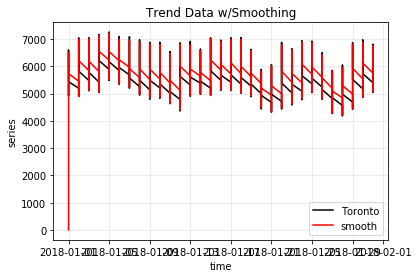

In [49]:
smoothed_trend = moving_average(df1["Toronto"].values, window=3, forecast=False)
run_sequence_plot(df1["Date"], df1["Toronto"],
                  title="Trend Data w/Smoothing")
plt.plot(df1["Date"].values[1:], np.insert(smoothed_trend,0,0), 'r', label="smooth")
plt.legend();

In [50]:
def ewma(observations, forecast=True):
    '''returns the exponentially weighted smoothed version of an array of observations.'''
    weights = np.array([0.160, 0.294, 0.543])
    output = np.zeros_like(observations, dtype='float')
    for i, _ in enumerate(observations):
        if (i == 0) or (i == 1) or (i == len(observations) - 1):
            pass
        else:
            output[i] = np.dot(observations[i-2:i+1], weights)
    if forecast:
        return np.insert(output, 0, 0)
    else:
        return output
    
ewma_smoothed_vals = ewma(df1["Toronto"].values, forecast=True)

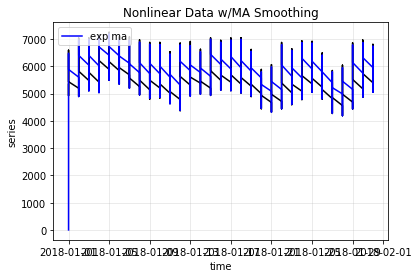

In [51]:
run_sequence_plot(df1["Date"].values, df1["Toronto"].values,
                  title="Nonlinear Data w/MA Smoothing")

plt.plot(df1["Date"].values, ewma_smoothed_vals[:-1], 'b', label="exp ma")
plt.legend(loc='upper left');

In [59]:
train = df1["Toronto"].values[:-3]
test = df1["Toronto"].values[-3:]

In [60]:
from statsmodels.tsa.api import ExponentialSmoothing

triple = ExponentialSmoothing(df1["Toronto"].values,
                              trend="additive",
                              seasonal="additive",
                              seasonal_periods=13).fit(optimized=True)
triple_preds = triple.forecast(len(test))
triple_mse = mse(test, triple_preds)
print("Predictions: ", triple_preds)
print("MSE: ", triple_mse)

Predictions:  [4939.97099328 4553.09810274 4244.18023134]
MSE:  4352921.895314084


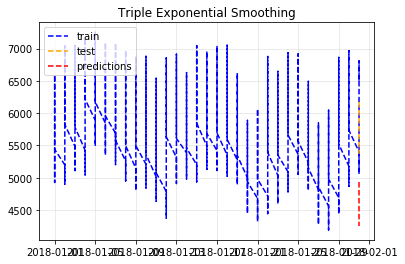

In [62]:
plt.plot(df1["Date"].values[:-3], train, 'b--', label="train")
plt.plot(df1["Date"].values[-3:], test, color='orange', linestyle="--", label="test")
plt.plot(df1["Date"].values[-3:], triple_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Triple Exponential Smoothing")
plt.grid(alpha=0.3);